In [41]:
import pandas as pd
import sys, os

# Add src module path
sys.path.append(os.path.abspath("../src"))

# Import necessary functions
from preprocessing import preprocess_reviews
from theme_extraction import extract_keywords_tfidf
from theme_grouping import group_keywords_into_themes

# Load cleaned review data
dashen = pd.read_csv("../Data/Dashen_Bank_reviews_20250606_130804_cleaned.csv")
cbe = pd.read_csv("../Data/Commercial_Bank_of_Ethiopia_reviews_20250606_130816_cleaned.csv")
boa = pd.read_csv("../Data/Bank_of_Abyssinia_reviews_20250606_130818_cleaned.csv")

# Add bank labels
dashen["bank"] = "Dashen Bank"
cbe["bank"] = "Commercial Bank of Ethiopia"
boa["bank"] = "Bank of Abyssinia"

# Combine all reviews
all_reviews = pd.concat([dashen, cbe, boa], ignore_index=True)

import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy's small English model (only tokenizer and lemmatizer needed)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def preprocess_reviews(df: pd.DataFrame, text_column: str = "review") -> pd.DataFrame:
    """
    Preprocess review text: tokenization, lowercasing, stopword removal, lemmatization.
    Adds a new column 'cleaned_review' to the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with reviews.
        text_column (str): Name of column containing raw review text.

    Returns:
        pd.DataFrame: DataFrame with new 'cleaned_review' column.
    """
    cleaned_reviews = []

    for doc in nlp.pipe(df[text_column].astype(str), batch_size=50):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha
        ]
        cleaned_reviews.append(" ".join(tokens))

    df["cleaned_review"] = cleaned_reviews
    return df



# ✅ Preprocess the review text (tokenization, stopword removal, lemmatization)
all_reviews = preprocess_reviews(all_reviews, text_column="review")

# Extract keywords using cleaned reviews
keywords = extract_keywords_tfidf(all_reviews, text_column="cleaned_review", top_n=50)

# Group extracted keywords into themes
theme_groups = group_keywords_into_themes(keywords)

# Display results
for bank, themes in theme_groups.items():
    print(f"\n🔹 {bank}")
    for theme, words in themes.items():
        print(f"  - {theme}: {', '.join(words)}")



🔹 Bank of Abyssinia
  - Other: good, work, bad, nice, bank, boa, crash, banking, mobile, like, ok, time, use, great, excellent, open, wow, fix, service, mobile banking, fast, poor, thank, developer, ነው, version, new, money, try, phone, amazing, properly, download, love, bug, experience
  - User Interface & Experience: app, good app, bad app, application, app work, banking app, easy
  - Feature Requests: update, need, option, developer option
  - Transaction Performance: slow, transaction, transfer

🔹 Commercial Bank of Ethiopia
  - Other: good, nice, work, like, ok, use, cbe, wow, bank, great, excellent, thank, fast, service, bad, time, banking, amazing, love, mobile, simple, money, account, new, mobile banking, perfect, problem, ethiopia, fix, best, ነው, በጣም, fantastic, network, send, developer
  - User Interface & Experience: app, good app, nice app, easy, application, easy use, great app, good application, like app
  - Feature Requests: update, need, option
  - Transaction Performan

In [44]:
# Convert the nested theme_groups dictionary to a flat list of rows
rows = []
for bank, themes in theme_groups.items():
    for theme, keywords in themes.items():
        rows.append({
            "bank": bank,
            "theme": theme,
            "keywords": ", ".join(keywords)
        })

# Create a DataFrame from the rows
theme_df = pd.DataFrame(rows)

# Export to CSV
theme_df.to_csv("../Data/thematic_grouping.csv", index=False)

print("✅ Saved: thematic_groupings.csv with cleaned + grouped keywords")


✅ Saved: thematic_groupings.csv with cleaned + grouped keywords


In [46]:
theme_df.head(20)

,bank,theme,keywords
0,Bank of Abyssinia,Other,"good, work, bad, nice, bank, boa, crash, banki..."
1,Bank of Abyssinia,User Interface & Experience,"app, good app, bad app, application, app work,..."
2,Bank of Abyssinia,Feature Requests,"update, need, option, developer option"
3,Bank of Abyssinia,Transaction Performance,"slow, transaction, transfer"
4,Commercial Bank of Ethiopia,Other,"good, nice, work, like, ok, use, cbe, wow, ban..."
5,Commercial Bank of Ethiopia,User Interface & Experience,"app, good app, nice app, easy, application, ea..."
6,Commercial Bank of Ethiopia,Feature Requests,"update, need, option"
7,Commercial Bank of Ethiopia,Transaction Performance,"transaction, transfer"
8,Dashen Bank,Other,"good, dashen, wow, bank, nice, super, fast, am..."
9,Dashen Bank,User Interface & Experience,"app, good app, easy, super app, application, e..."


🧠 Thematic Analysis Interpretation of Customer Reviews
We applied TF-IDF keyword extraction followed by manual theme grouping across user reviews of three major Ethiopian banking apps. The following insights emerged:

🔹 1. Common Themes Across All Banks
Each bank exhibited four primary themes:

User Interface & Experience (UI/UX): Keywords like app, good app, application, and easy highlight how users consistently comment on app usability and design.

Feature Requests: Terms such as update, need, and option show that users are actively requesting improvements or new functionalities.

Transaction Performance: Keywords like transaction, transfer, and slow suggest that performance—particularly in financial operations—is a consistent pain point.

Other: This category captures more general sentiment (e.g., good, nice, bad) or unrelated terms. These reviews are often vague but still valuable for tone assessment.

🔹 2. Bank-Specific Observations
🟦 Bank of Abyssinia
UI/UX concerns are fairly prominent, with repeated mentions of bad app and crash, indicating stability issues.

Transaction performance is discussed with keywords like slow, suggesting delays or failures.

Feature gaps like developer option were uniquely mentioned here, hinting at more technical user expectations.

🟧 Commercial Bank of Ethiopia (CBE)
App simplicity is appreciated (easy, nice), but transaction and feature issues are still present.

Positive feedback like wow and use appear frequently, suggesting a broader user base with varying experiences.

🟩 Dashen Bank
Receives relatively more positive sentiment (keywords like super, fast, amazing) in the “Other” category.

Still shares common concerns in UI/UX and feature requests, but the tone appears slightly more optimistic.

📌 Summary
This analysis shows:

A shared set of user priorities across all three apps (ease of use, features, transaction performance).

Opportunities to improve app stability, introduce requested features, and enhance transaction reliability.

Slight tone differences per bank, with Dashen skewing more positive and BOA more negative in sentiment.

These thematic insights should guide targeted UX and engineering improvements for each banking app.

In [4]:
# Step 1: Imports
import pandas as pd
import sys, os
sys.path.append(os.path.abspath("../src"))
from preprocessing import preprocess_reviews
from theme_extraction import extract_keywords_tfidf
from theme_grouping import group_keywords_into_themes
from theme_assignment import assign_theme_to_review

# Step 2: Define sentiment sources
sentiment_sources = {
    "DistilBERT": {
        "BOA": "../Data/BOA_reviews_with_sentiment_DistilBERT.csv",
        "CBE": "../Data/CBE_reviews_with_sentiment_DistilBERT.csv",
        "Dashen": "../Data/Dashen_Bank_reviews_with_sentiment_DistilBERT.csv"
    },
    "VADER": {
        "BOA": "../Data/BOA_reviews_with_sentiment_VADER.csv",
        "CBE": "../Data/CBE_reviews_with_sentiment_VADER.csv",
        "Dashen": "../Data/Dashen_Bank_reviews_with_sentiment_VADER.csv"
    },
    "TextBlob": {
        "BOA": "../Data/BOA_reviews_with_sentiment_TextBlob.csv",
        "CBE": "../Data/CBE_reviews_with_sentiment_TextBlob.csv",
        "Dashen": "../Data/Dashen_Bank_reviews_with_sentiment_TextBlob.csv"
    }
}

# Step 3: Process each sentiment method
for method, paths in sentiment_sources.items():
    print(f"\n🔁 Processing {method} sentiment...")

    # Load data
    boa = pd.read_csv(paths["BOA"])
    cbe = pd.read_csv(paths["CBE"])
    dashen = pd.read_csv(paths["Dashen"])

    # Add bank labels
    boa["bank"] = "Bank of Abyssinia"
    cbe["bank"] = "Commercial Bank of Ethiopia"
    dashen["bank"] = "Dashen Bank"

    # Combine all reviews
    all_reviews = pd.concat([boa, cbe, dashen], ignore_index=True)

    # Preprocess reviews
    all_reviews = preprocess_reviews(all_reviews, "review")

    # Extract keywords and group into themes (only once, could be moved outside loop if themes don't depend on sentiment)
    top_keywords = extract_keywords_tfidf(all_reviews, "cleaned_review", top_n=50)
    theme_groups = group_keywords_into_themes(top_keywords)

    # Assign theme to each review
    all_reviews["assigned_theme"] = all_reviews.apply(
        lambda row: assign_theme_to_review(row["cleaned_review"], row["bank"], theme_groups),
        axis=1
    )

    # Export final results
    final_df = all_reviews[["bank", "review", "sentiment_score", "sentiment_label", "assigned_theme"]]
    out_path = f"../Data/final_reviews_with_sentiment_and_themes_{method}.csv"
    final_df.to_csv(out_path, index=False)

    print(f"✅ Saved: {out_path}")
    from IPython.display import display
    print(f"\n🔍 Preview of {method} results:")
    display(final_df.head(10))



🔁 Processing DistilBERT sentiment...
✅ Saved: ../Data/final_reviews_with_sentiment_and_themes_DistilBERT.csv

🔍 Preview of DistilBERT results:


,bank,review,sentiment_score,sentiment_label,assigned_theme
0,Bank of Abyssinia,it's not working,0.999786,negative,Transaction Performance
1,Bank of Abyssinia,"Hello, I’m facing a problem with the BOA Mobil...",0.999415,negative,User Interface & Experience
2,Bank of Abyssinia,exceptional,0.999851,positive,Other
3,Bank of Abyssinia,BoA Mobile good bank,0.998473,positive,General Sentiment & Feedback
4,Bank of Abyssinia,this is worest app 24/7 loading,0.993474,negative,User Interface & Experience
5,Bank of Abyssinia,This App is not interest for Android phone Ple...,0.997138,negative,User Interface & Experience
6,Bank of Abyssinia,BoA system is confartable,0.998014,negative,Other
7,Bank of Abyssinia,very nice Abyssinia bank is choice all,0.999583,positive,User Interface & Experience
8,Bank of Abyssinia,"this app, for me , is a waste of time. It does...",0.999805,negative,User Interface & Experience
9,Bank of Abyssinia,Good service.,0.999853,positive,General Sentiment & Feedback



🔁 Processing VADER sentiment...
✅ Saved: ../Data/final_reviews_with_sentiment_and_themes_VADER.csv

🔍 Preview of VADER results:


,bank,review,sentiment_score,sentiment_label,assigned_theme
0,Bank of Abyssinia,it's not working,0.0000,neutral,Transaction Performance
1,Bank of Abyssinia,"Hello, I’m facing a problem with the BOA Mobil...",-0.1884,negative,User Interface & Experience
2,Bank of Abyssinia,exceptional,0.0000,neutral,Other
3,Bank of Abyssinia,BoA Mobile good bank,0.4404,positive,General Sentiment & Feedback
4,Bank of Abyssinia,this is worest app 24/7 loading,0.0000,neutral,User Interface & Experience
5,Bank of Abyssinia,This App is not interest for Android phone Ple...,-0.0464,neutral,User Interface & Experience
6,Bank of Abyssinia,BoA system is confartable,0.0000,neutral,Other
7,Bank of Abyssinia,very nice Abyssinia bank is choice all,0.4754,positive,User Interface & Experience
8,Bank of Abyssinia,"this app, for me , is a waste of time. It does...",-0.8491,negative,User Interface & Experience
9,Bank of Abyssinia,Good service.,0.4404,positive,General Sentiment & Feedback



🔁 Processing TextBlob sentiment...
✅ Saved: ../Data/final_reviews_with_sentiment_and_themes_TextBlob.csv

🔍 Preview of TextBlob results:


,bank,review,sentiment_score,sentiment_label,assigned_theme
0,Bank of Abyssinia,it's not working,0.000000,neutral,Transaction Performance
1,Bank of Abyssinia,"Hello, I’m facing a problem with the BOA Mobil...",0.033333,neutral,User Interface & Experience
2,Bank of Abyssinia,exceptional,0.666667,positive,Other
3,Bank of Abyssinia,BoA Mobile good bank,0.700000,positive,General Sentiment & Feedback
4,Bank of Abyssinia,this is worest app 24/7 loading,0.000000,neutral,User Interface & Experience
5,Bank of Abyssinia,This App is not interest for Android phone Ple...,0.000000,neutral,User Interface & Experience
6,Bank of Abyssinia,BoA system is confartable,0.000000,neutral,Other
7,Bank of Abyssinia,very nice Abyssinia bank is choice all,0.780000,positive,User Interface & Experience
8,Bank of Abyssinia,"this app, for me , is a waste of time. It does...",-0.016667,neutral,User Interface & Experience
9,Bank of Abyssinia,Good service.,0.700000,positive,General Sentiment & Feedback


In [5]:


# Step 1: Load each CSV
distilbert_df = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_DistilBERT.csv")
vader_df = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_VADER.csv")
textblob_df = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_TextBlob.csv")

# Step 2: Add method column to each
distilbert_df["method"] = "DistilBERT"
vader_df["method"] = "VADER"
textblob_df["method"] = "TextBlob"

# Step 3: Concatenate into one DataFrame
combined_df = pd.concat([distilbert_df, vader_df, textblob_df], ignore_index=True)

# Step 4: Export to a single CSV
combined_df.to_csv("../Data/combined_reviews_with_sentiment_and_themes.csv", index=False)

# Step 5: Show the head of the combined DataFrame
from IPython.display import display
display(combined_df.head(10))

print("✅ Combined CSV saved as: combined_reviews_with_sentiment_and_themes.csv")


,bank,review,sentiment_score,sentiment_label,assigned_theme,method
0,Bank of Abyssinia,it's not working,0.999786,negative,Transaction Performance,DistilBERT
1,Bank of Abyssinia,"Hello, I’m facing a problem with the BOA Mobil...",0.999415,negative,User Interface & Experience,DistilBERT
2,Bank of Abyssinia,exceptional,0.999851,positive,Other,DistilBERT
3,Bank of Abyssinia,BoA Mobile good bank,0.998473,positive,General Sentiment & Feedback,DistilBERT
4,Bank of Abyssinia,this is worest app 24/7 loading,0.993474,negative,User Interface & Experience,DistilBERT
5,Bank of Abyssinia,This App is not interest for Android phone Ple...,0.997138,negative,User Interface & Experience,DistilBERT
6,Bank of Abyssinia,BoA system is confartable,0.998014,negative,Other,DistilBERT
7,Bank of Abyssinia,very nice Abyssinia bank is choice all,0.999583,positive,User Interface & Experience,DistilBERT
8,Bank of Abyssinia,"this app, for me , is a waste of time. It does...",0.999805,negative,User Interface & Experience,DistilBERT
9,Bank of Abyssinia,Good service.,0.999853,positive,General Sentiment & Feedback,DistilBERT


✅ Combined CSV saved as: combined_reviews_with_sentiment_and_themes.csv


In [8]:
import pandas as pd

# Step 1: Load each CSV
distilbert = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_DistilBERT.csv")
vader = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_VADER.csv")
textblob = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_TextBlob.csv")

# Step 2: Rename columns for clarity
distilbert = distilbert.rename(columns={
    "sentiment_score": "sentiment_score_distilbert",
    "sentiment_label": "sentiment_label_distilbert",
    "assigned_theme": "theme_distilbert"
})

vader = vader.rename(columns={
    "sentiment_score": "sentiment_score_vader",
    "sentiment_label": "sentiment_label_vader",
    "assigned_theme": "theme_vader"
})

textblob = textblob.rename(columns={
    "sentiment_score": "sentiment_score_textblob",
    "sentiment_label": "sentiment_label_textblob",
    "assigned_theme": "theme_textblob"
})

# Step 3: Merge on `review` and `bank`
merged = distilbert[["bank", "review", "sentiment_score_distilbert", "sentiment_label_distilbert", "theme_distilbert"]] \
    .merge(vader[["bank", "review", "sentiment_score_vader", "sentiment_label_vader", "theme_vader"]],
           on=["bank", "review"], how="inner") \
    .merge(textblob[["bank", "review", "sentiment_score_textblob", "sentiment_label_textblob", "theme_textblob"]],
           on=["bank", "review"], how="inner")

merged = merged[["bank", "review", "sentiment_label_distilbert", ..., "theme_textblob"]]

# Step 4: Save and preview
merged.to_csv("../Data/merged_comparison_reviews.csv", index=False)

from IPython.display import display
display(merged.head(10))

print("✅ Merged comparison CSV saved as: merged_comparison_reviews.csv")


KeyError: '[Ellipsis] not in index'

In [7]:
merged.shape

(18202207, 11)

In [11]:
import pandas as pd
from IPython.display import display

# Step 1: Load each CSV
distilbert = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_DistilBERT.csv")
vader = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_VADER.csv")
textblob = pd.read_csv("../Data/final_reviews_with_sentiment_and_themes_TextBlob.csv")

# Step 2: Rename columns to identify their source
distilbert = distilbert.rename(columns={
    "sentiment_score": "sentiment_score_distilbert",
    "sentiment_label": "sentiment_label_distilbert",
    "assigned_theme": "theme"  # Use just one theme column
})

vader = vader.rename(columns={
    "sentiment_score": "sentiment_score_vader",
    "sentiment_label": "sentiment_label_vader"
    # No theme column needed
})

textblob = textblob.rename(columns={
    "sentiment_score": "sentiment_score_textblob",
    "sentiment_label": "sentiment_label_textblob"
    # No theme column needed
})

# Step 3: Merge on 'bank' and 'review'
merged = distilbert[["bank", "review", "theme", "sentiment_score_distilbert", "sentiment_label_distilbert"]] \
    .merge(vader[["bank", "review", "sentiment_score_vader", "sentiment_label_vader"]],
           on=["bank", "review"], how="inner") \
    .merge(textblob[["bank", "review", "sentiment_score_textblob", "sentiment_label_textblob"]],
           on=["bank", "review"], how="inner")

# Step 4: Drop duplicates if any
merged = merged.drop_duplicates(subset=["bank", "review"])

# Step 5: Save to CSV
merged.to_csv("../Data/merged_comparison_review.csv", index=False)

# Step 6: Preview the result
display(merged.head(10))
print(f"✅ Merged file saved successfully. Rows: {len(merged)} | Columns: {merged.shape[1]}")


,bank,review,theme,sentiment_score_distilbert,sentiment_label_distilbert,sentiment_score_vader,sentiment_label_vader,sentiment_score_textblob,sentiment_label_textblob
0,Bank of Abyssinia,it's not working,Transaction Performance,0.999786,negative,0.0000,neutral,0.000000,neutral
1,Bank of Abyssinia,"Hello, I’m facing a problem with the BOA Mobil...",User Interface & Experience,0.999415,negative,-0.1884,negative,0.033333,neutral
2,Bank of Abyssinia,exceptional,Other,0.999851,positive,0.0000,neutral,0.666667,positive
3,Bank of Abyssinia,BoA Mobile good bank,General Sentiment & Feedback,0.998473,positive,0.4404,positive,0.700000,positive
4,Bank of Abyssinia,this is worest app 24/7 loading,User Interface & Experience,0.993474,negative,0.0000,neutral,0.000000,neutral
5,Bank of Abyssinia,This App is not interest for Android phone Ple...,User Interface & Experience,0.997138,negative,-0.0464,neutral,0.000000,neutral
6,Bank of Abyssinia,BoA system is confartable,Other,0.998014,negative,0.0000,neutral,0.000000,neutral
7,Bank of Abyssinia,very nice Abyssinia bank is choice all,User Interface & Experience,0.999583,positive,0.4754,positive,0.780000,positive
8,Bank of Abyssinia,"this app, for me , is a waste of time. It does...",User Interface & Experience,0.999805,negative,-0.8491,negative,-0.016667,neutral
9,Bank of Abyssinia,Good service.,General Sentiment & Feedback,0.999853,positive,0.4404,positive,0.700000,positive


✅ Merged file saved successfully. Rows: 4945 | Columns: 9


vizulaition

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load merged dataset
df = pd.read_csv("../Data/merged_comparison_review.csv")


📊 Plot 1: Sentiment Label Distribution per Model

C:\Users\User\AppData\Local\Temp\ipykernel_18948\1570427160.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label_distilbert", palette="pastel")
C:\Users\User\AppData\Local\Temp\ipykernel_18948\1570427160.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label_vader", palette="pastel")
C:\Users\User\AppData\Local\Temp\ipykernel_18948\1570427160.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label_textblob", palette="pastel")


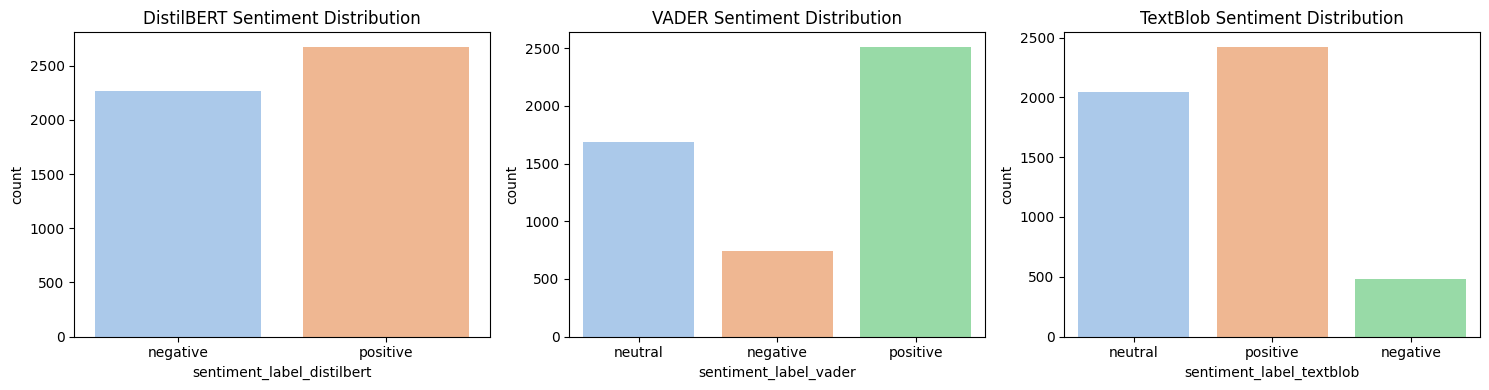

In [13]:
plt.figure(figsize=(15, 4))

# DistilBERT
plt.subplot(1, 3, 1)
sns.countplot(data=df, x="sentiment_label_distilbert", palette="pastel")
plt.title("DistilBERT Sentiment Distribution")

# VADER
plt.subplot(1, 3, 2)
sns.countplot(data=df, x="sentiment_label_vader", palette="pastel")
plt.title("VADER Sentiment Distribution")

# TextBlob
plt.subplot(1, 3, 3)
sns.countplot(data=df, x="sentiment_label_textblob", palette="pastel")
plt.title("TextBlob Sentiment Distribution")

plt.tight_layout()
plt.show()


In [ ]:
📊 Plot 2: Sentiment Score Distribution

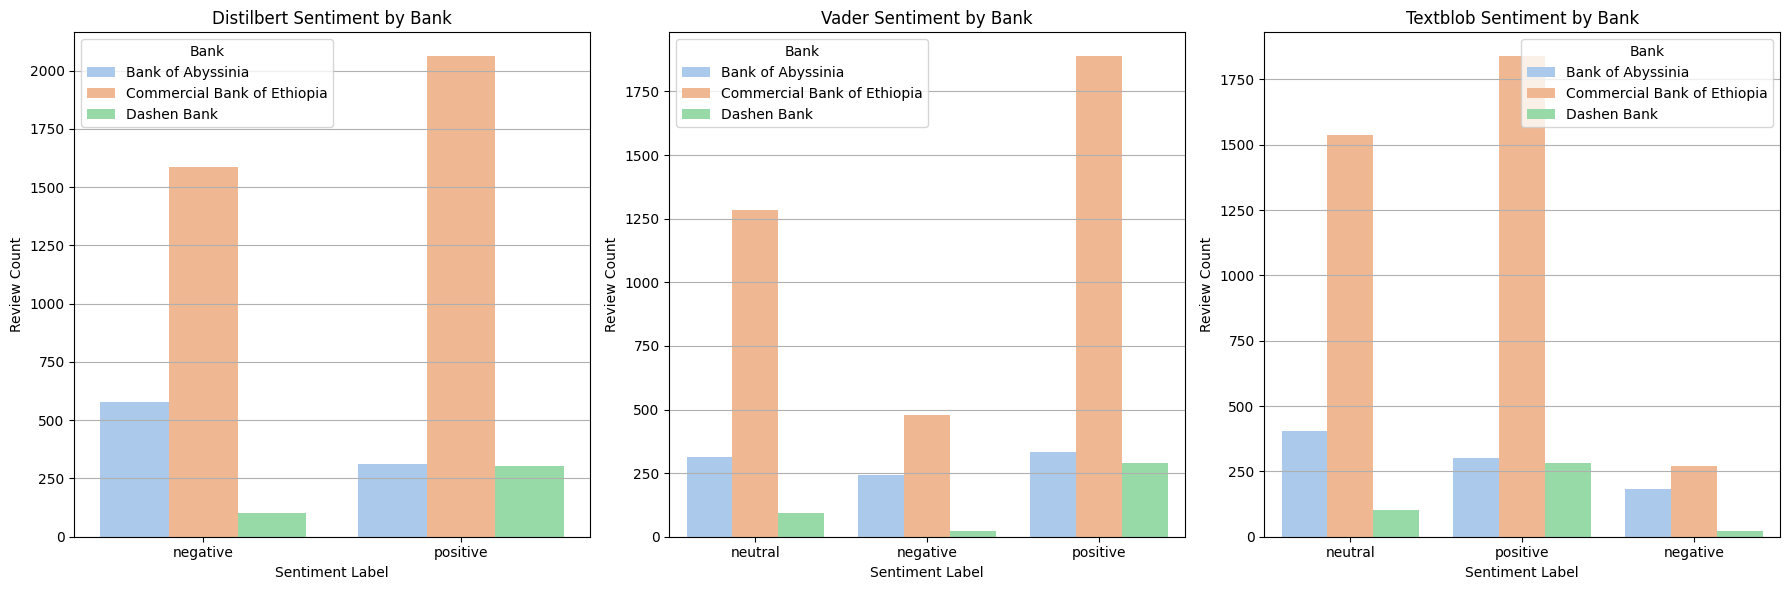

In [15]:
import matplotlib.ticker as mtick

plt.figure(figsize=(18, 6))
models = ["distilbert", "vader", "textblob"]
for i, model in enumerate(models):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=df, x=f"sentiment_label_{model}", hue="bank", palette="pastel")
    plt.title(f"{model.title()} Sentiment by Bank")
    plt.xlabel("Sentiment Label")
    plt.ylabel("Review Count")
    plt.legend(title="Bank")
    plt.grid(axis='y')

plt.tight_layout()
plt.show()


Key Insights:
Commercial Bank of Ethiopia has the highest number of reviews across all sentiment categories.

Dashen Bank has fewer reviews but maintains a higher proportion of positive feedback compared to negative.

Bank of Abyssinia shows a balanced distribution between negative and positive reviews, with a moderate neutral sentiment.

C:\Users\User\AppData\Local\Temp\ipykernel_18948\3258692175.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="bank", y=f"sentiment_score_{model}", palette="pastel")
C:\Users\User\AppData\Local\Temp\ipykernel_18948\3258692175.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="bank", y=f"sentiment_score_{model}", palette="pastel")
C:\Users\User\AppData\Local\Temp\ipykernel_18948\3258692175.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="bank", y=f"sentiment_score_{model}", palette="pastel")


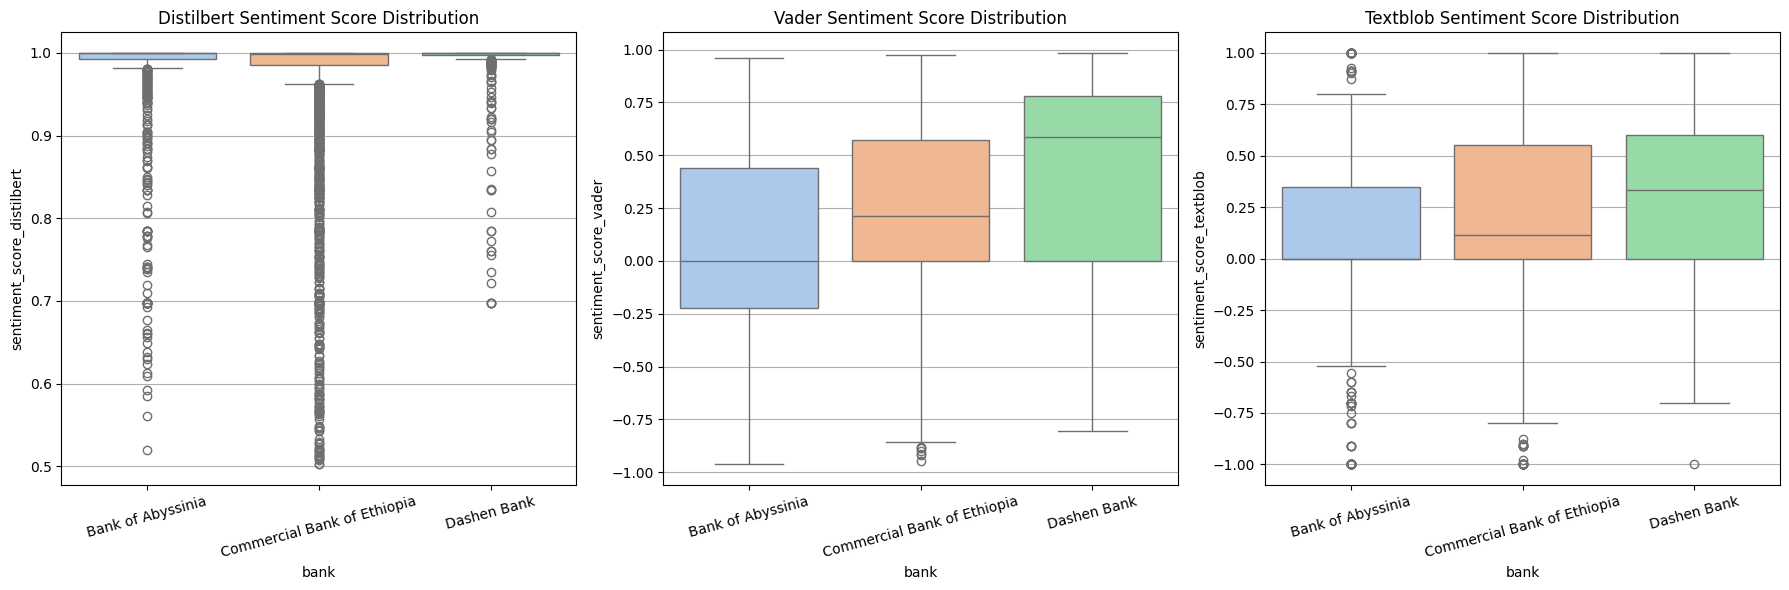

In [16]:
plt.figure(figsize=(18, 6))
for i, model in enumerate(models):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x="bank", y=f"sentiment_score_{model}", palette="pastel")
    plt.title(f"{model.title()} Sentiment Score Distribution")
    plt.xticks(rotation=15)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()


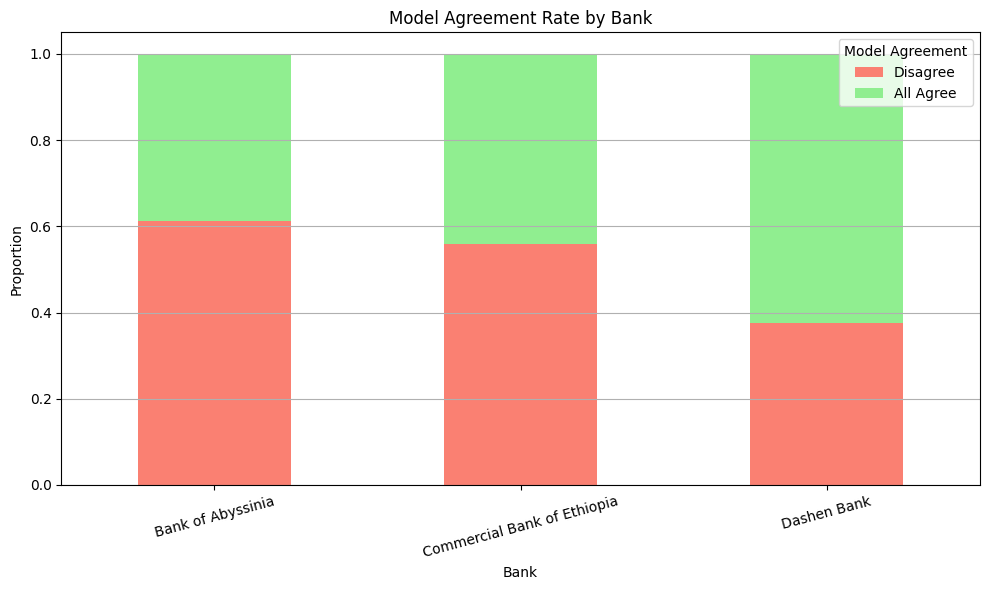

In [17]:
# Add agreement column again
df["agreement_all"] = (df["sentiment_label_distilbert"] == df["sentiment_label_vader"]) & \
                      (df["sentiment_label_distilbert"] == df["sentiment_label_textblob"])

# Group by bank
agreement_by_bank = df.groupby("bank")["agreement_all"].value_counts(normalize=True).unstack().fillna(0)

# Barplot
agreement_by_bank.plot(kind="bar", stacked=True, figsize=(10, 6), color=["salmon", "lightgreen"])
plt.title("Model Agreement Rate by Bank")
plt.ylabel("Proportion")
plt.xlabel("Bank")
plt.legend(["Disagree", "All Agree"], title="Model Agreement")
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Sentiment Label Heatmap (Frequency Table)

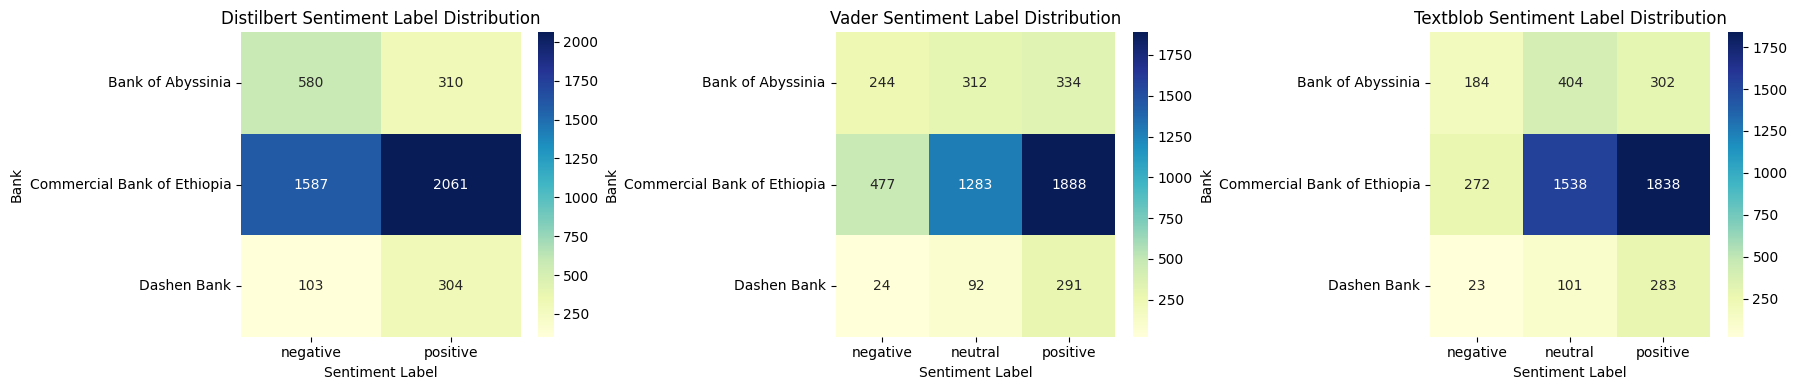

In [19]:
# Pivot tables for each model
pivot_tables = {}
models = ["distilbert", "vader", "textblob"]
for model in models:
    pivot = df.pivot_table(index="bank", columns=f"sentiment_label_{model}", aggfunc="size", fill_value=0)
    pivot_tables[model] = pivot

# Display heatmaps
plt.figure(figsize=(18, 4))
for i, model in enumerate(models):
    plt.subplot(1, 3, i+1)
    sns.heatmap(pivot_tables[model], annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"{model.title()} Sentiment Label Distribution")
    plt.xlabel("Sentiment Label")
    plt.ylabel("Bank")

plt.tight_layout()
plt.show()


🔍 Sentiment Label Distribution by Bank and Model
The heatmap below compares how three sentiment analysis models — DistilBERT, VADER, and TextBlob — classify user reviews across three major Ethiopian banks:

Bank of Abyssinia

Commercial Bank of Ethiopia (CBE)

Dashen Bank

Each subplot represents the frequency of positive, neutral, and negative sentiment labels assigned by a model to each bank's reviews.

Key Insights:
CBE consistently receives the highest number of reviews, with a dominant share of positive sentiment across all models.

Bank of Abyssinia has a more balanced spread but still leans positive; VADER and TextBlob label more reviews as neutral compared to DistilBERT.

Dashen Bank has the fewest reviews overall, yet shows a relatively high positive-to-negative ratio, especially in VADER and TextBlob outputs.

DistilBERT appears more polarized, classifying fewer neutral reviews compared to the lexicon-based models (VADER and TextBlob).

This comparison helps reveal how different models interpret sentiment in user reviews and offers a multidimensional perspective on perceived customer satisfaction per bank.